# Analysis of drug-disease relation pair cooccurence in the gold standard data of BioCreative V

2015-06-23 Tong Shu Li

I want to simplify the task that members of our crowd see, in the belief that simpler tasks will provide better performance.

The biggest simplification is whether we can extract the same drug-disease relationships from single sentences only, or if we need to include the entire abstract. To answer this, we will need to know which drug-disease relationships co-occur in the same sentence.

In [1]:
from __future__ import division
from collections import defaultdict
import nltk
import pandas as pd
import matplotlib as plt

In [2]:
%matplotlib inline

In [3]:
from src.parse_gold import parse_input
from src.parse_gold import Relation

### Read the gold standard files:

In [4]:
training_data = parse_input("data/training", "CDR_TrainingSet.txt")
development_data = parse_input("data/development", "CDR_DevelopmentSet.txt")

In [5]:
print len(training_data)
print len(development_data)

500
500


---

###Workflow:

1. Split each abstract up into sentences, and determine the starting and end indicies of each sentence. Determine using a rough heuristic whether each abstract was split up properly.
2. Generate all possible drug-disease pairs, and look for co-occurrences. Determine if is a gold relation.

### Try to split the sentences up:

We will use a modified version of the standard English PunktSentence Tokenizer from the Python NLTK corpus to split our abstract into sentences. The default splitter is very good, but misses a lot of scientific abbreviations. We will train it on some commonly used acronyms, but the list is definitely not exhaustive.

In [6]:
def generate_all_abbreviations():
    examples = []
            
    abrev = """mg. kg-1 d-1
Gm.
mEq.
mg.
ng./ml.
M.S.
ml.
i.e.
100 mg/kg/i.p.
beats/min.
i.m.
apples vs. oranges
t.d.s.
t.i.d.
b.i.d.
mg. l(-1)
mg.
i.c.v."""
    
    for token in abrev.split('\n'):
        examples.append("Sentences with {0} should be ignored.".format(token))

    return "\n".join(examples)

In [7]:
# old training text made by hand:
train_text = """
Sentences with i.v. should be ignored.
Sentences with apples vs. oranges should be ignored.
Sentences with dose given at 100 mg t.d.s. should be ignored.
Sentences with i.p. should be ignored.
Sentences with s.c. should be ignored.
Sentences with t.i.d. should be ignored.
Sentences with b.i.d. should be ignored.
Sentences with e.g. should be ignored.
Sentences with mg. l(-1) should be ignored.
Sentences with 9:00 a.m. or 10:00 p.m. should be ignored.
Sentences with i.c.v. should be ignored.
Sentences with p.o. should be ignored.
Sentences with i.p. should be ignored.
Sentences with s.c. should be ignored.
"""

In [8]:
train_text += generate_all_abbreviations()

### We need our own tokenizer for scientific sentences, since there are lots of acronyms and scientific units

In [9]:
science_sent_tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer(train_text)

The science tokenizer doesn't work perfectly. In some cases, it is still getting tripped up by units and abbreviations which end with a period. This will affect the percentage of concepts co-occurring in the same sentence, but the overall effect is small.

In [10]:
def split_paper(paper):
    """
    Given a paper object, splits it up into
    sentences and determines the index span.
    """
    text = "{0} {1}".format(paper.title, paper.abstract)
    
    data = defaultdict(list)
    
    sentences = [paper.title] + science_sent_tokenizer.tokenize(paper.abstract)
    data["sentences"] = sentences
    
    for sentence in sentences:
        data["made_mistake"].append(int('a' <= sentence[0] <= 'z'))
            
        idx = text.index(sentence)
        data["start_index"].append(idx)
        data["stop_index"].append(idx + len(sentence))
        
    data["pmid"] = paper.pmid
        
    return pd.DataFrame(data)

In [11]:
def split_papers(document_set):
    return pd.concat([split_paper(paper) for paper in document_set])    

In [12]:
training_info = split_papers(training_data)
development_info = split_papers(development_data)

In [13]:
training_info.shape

(4563, 5)

In [14]:
development_info.shape

(4569, 5)

The sentence_info data frame contains all the sentences from both the training and development data sets:

In [15]:
sentence_info = pd.concat([training_info, development_info])
sentence_info.head()

,made_mistake,pmid,sentences,start_index,stop_index
0,0,227508,Naloxone reverses the antihypertensive effect ...,0,59
1,0,227508,"In unanesthetized, spontaneously hypertensive ...",60,269
2,0,227508,The hypotensive effect of 100 mg/kg alpha-meth...,270,363
3,0,227508,Naloxone alone did not affect either blood pre...,364,430
4,0,227508,In brain membranes from spontaneously hyperten...,431,703


### Generate the list of all possible drug-disease pairs, and look to see if they co-occur in the same sentence:

In [16]:
def get_all_work_units(paper):
    """
    Generate all unique drug-disease pairs by unique identifier.
    Return a list.
    """
    uniq = defaultdict(set)
    for annotation in paper.annotations:
        uniq[annotation.stype].add(annotation.uid)
        
    return [(drug, disease) for drug in uniq["chemical"] for disease in uniq["disease"]]

In [17]:
def determine_cooccurence(paper, relation_pairs, sentence_info):
    """
    Given a paper and a list of drug-disease pairs,
    determines how many times each drug-disease pair
    co-occurs in the same sentence.
    """
    
    def get_distances(drug_id, disease_id):
        """
        Calculate the minimum, median, and maximum
        distance in characters between two concept
        mentions.
        """
        res = []
        for annot in paper.annotations:
            if annot.uid == drug_id:
                for other in paper.annotations:
                    if other.uid == disease_id:
                        res.append(max(annot.start, other.start) - min(annot.stop, other.stop))
                        
        res = pd.Series(res)
        return (min(res), res.median(), max(res))
    
    # which concept ids each sentence contains
    concepts = defaultdict(set)
    for idx, row in sentence_info.iterrows():
        start = row["start_index"]
        stop = row["stop_index"]
        
        for annotation in paper.annotations:
            if annotation.start >= start and annotation.stop <= stop:
                concepts[idx].add(annotation.uid)
    
    # count co-occurrences
    data = defaultdict(list)
    for drug_id, disease_id in relation_pairs:
        times_cooccur = 0
        for sent_id, concept_set in concepts.items():
            if drug_id in concept_set and disease_id in concept_set:
                times_cooccur += 1
                
        data["times_cooccur"].append(times_cooccur)
        data["is_true"].append(Relation(drug_id, disease_id) in paper.relations)
        data["id_pair"].append("{0}|{1}".format(drug_id, disease_id))
        
        # find the distance between the concept annotations
        min_dist, med_dist, max_dist = get_distances(drug_id, disease_id)
        data["minimum_dist"].append(min_dist)
        data["median_dist"].append(med_dist)
        data["maximum_dist"].append(max_dist)
        
    res = pd.DataFrame(data)
    res["pmid"] = paper.pmid
    
    return res

In [18]:
def cooccur_results(data_frame):
    res = []
    for paper in data_frame:
        work_units = get_all_work_units(paper)
        df = sentence_info.query("pmid == '{0}'".format(paper.pmid))
        
        res.append(determine_cooccurence(paper, work_units, df))
        
    return pd.concat(res)

In [19]:
train_res = cooccur_results(training_data)
develop_res = cooccur_results(development_data)

### Now that we have the cooccurence counts, we can see if this can be used to filter our data:

In [20]:
train_res.shape

(5399, 7)

In [21]:
develop_res.shape

(5175, 7)

In [22]:
train_res.head()

,id_pair,is_true,maximum_dist,median_dist,minimum_dist,times_cooccur,pmid
0,D003000|D006973,False,921,330.5,6,2,227508
1,D003000|D007022,False,741,284.0,84,0,227508
2,D008750|D006973,False,934,352.5,147,0,227508
3,D008750|D007022,True,754,387.5,21,1,227508
4,D009270|D006973,False,760,259.0,85,1,227508


In [23]:
develop_res.head()

,id_pair,is_true,maximum_dist,median_dist,minimum_dist,times_cooccur,pmid
0,D016651|D001145,True,637,398.5,160,0,6794356
1,D016651|D014262,False,482,218.5,5,1,6794356
2,D016651|D064420,False,451,226.0,1,1,6794356
3,D016651|D001282,False,367,223.0,79,0,6794356
4,D016651|D003490,True,623,384.5,146,0,6794356


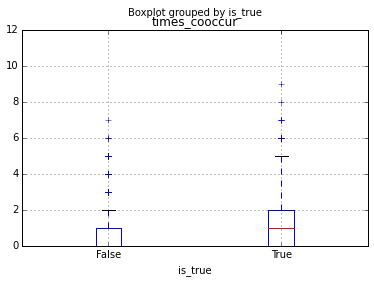

In [24]:
train_res.boxplot(column = "times_cooccur", by = "is_true")

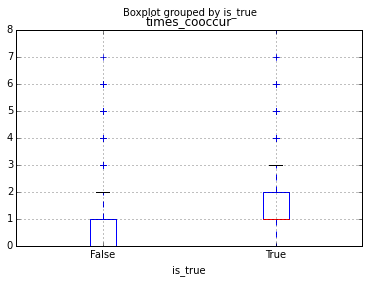

In [25]:
develop_res.boxplot(column = "times_cooccur", by = "is_true")

### For the pairs which are true according to the gold, it seems that they tend to cooccur more often

This is good, but when we don't know whether a potential drug-disease pair is true or not, can we use the number of cooccurences to determine whether the relationship is likely to be true or not?

In [26]:
train_no_cooccur = train_res.query("times_cooccur == 0")
develop_no_cooccur = develop_res.query("times_cooccur == 0")

In [27]:
len(train_no_cooccur) / len(train_res)

0.5719577699573996

In [28]:
len(develop_no_cooccur) / len(develop_res)

0.5281159420289855

Roughly half of the possible relations never show up in the same sentence. Now let's see if these relations are likely to be true:

In [29]:
len(train_no_cooccur.query("is_true")) / len(train_no_cooccur)

0.08743523316062177

In [30]:
len(develop_no_cooccur.query("is_true")) / len(develop_no_cooccur)

0.08342480790340286

These data show that roughly 8% of the possible relations which don't show up in the same sentence are true.

In [31]:
train_do_cooccur = train_res.query("times_cooccur > 0")
develop_do_cooccur = develop_res.query("times_cooccur > 0")

In [32]:
len(train_do_cooccur) / len(train_res)

0.4280422300426005

In [33]:
len(develop_do_cooccur) / len(develop_res)

0.4718840579710145

And now the possibility to be true:

In [34]:
len(train_do_cooccur.query("is_true")) / len(train_do_cooccur)

0.30938987451319777

In [35]:
len(develop_do_cooccur.query("is_true")) / len(develop_do_cooccur)

0.29975429975429974

So the drug-disease pairs which show up in the same sentence even once are 4x more likely to be true than those which don't show up together in the same sentence.

In [36]:
len(train_res.query("is_true"))

985

In [37]:
len(develop_res.query("is_true"))

960

In [38]:
len(train_no_cooccur.query("is_true"))

270

In [39]:
len(develop_no_cooccur.query('is_true'))

228

In [40]:
len(train_do_cooccur.query("is_true"))

715

In [41]:
len(develop_do_cooccur.query("is_true"))

732

### Based on these results, it seems that we might be able to safely split the task into two subtasks:

One subtask would have to read the entire abstract for the non-cooccuring relations, while the other subtask would read single sentences (or collections of sentence) where the terms cooccur.

In [42]:
train_no_cooccur.head()

,id_pair,is_true,maximum_dist,median_dist,minimum_dist,times_cooccur,pmid
1,D003000|D007022,False,741,284.0,84,0,227508
2,D008750|D006973,False,934,352.5,147,0,227508
1,D010830|D062787,False,27,27.0,27,0,603022
0,D003404|D006973,False,334,239.0,144,0,1378968
1,D003404|D011507,False,300,235.0,170,0,1378968


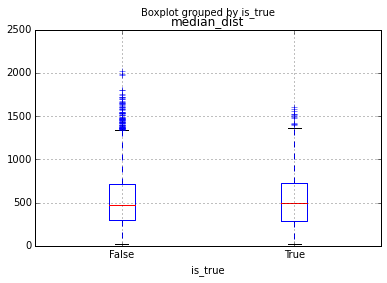

In [43]:
train_no_cooccur.boxplot(column = "median_dist", by = "is_true")

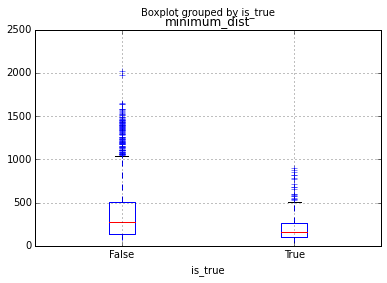

In [44]:
train_no_cooccur.boxplot(column = "minimum_dist", by = "is_true")

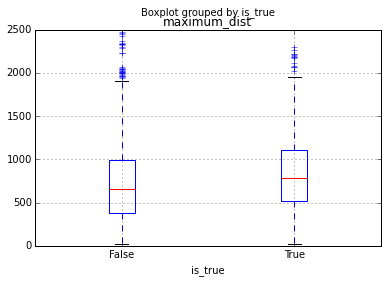

In [45]:
train_no_cooccur.boxplot(column = "maximum_dist", by = "is_true")

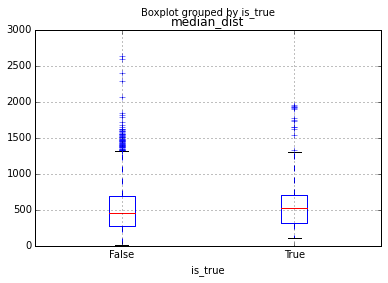

In [46]:
develop_no_cooccur.boxplot(column = "median_dist", by = "is_true")

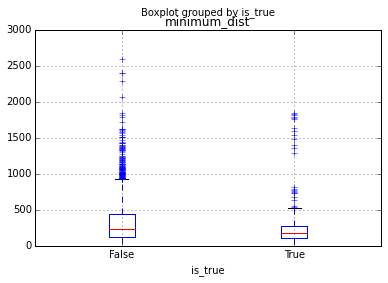

In [47]:
develop_no_cooccur.boxplot(column = "minimum_dist", by = "is_true")

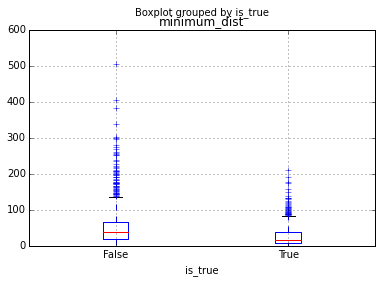

In [48]:
develop_do_cooccur.boxplot(column = "minimum_dist", by = "is_true")

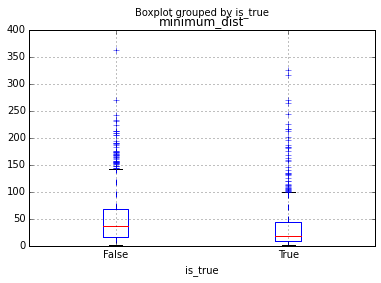

In [50]:
train_do_cooccur.boxplot(column = "minimum_dist", by = "is_true")

In conclusion, we will likely be able to separate the drug-induced-disease extraction task into two subtasks, one where workers are shown sentences containing both terms, and one where workers are shown the entire abstract.

The analysis of distance separating two terms shows that in general, the minimum distance between two concepts which are not related tends to be farther apart then concepts which are related, in both the co-occurring and non-co-occurring cases.

However, the distance heuristic does not seem good enough to act as a preprocessing filter for deciding which task to direct the data towards.